In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import seaborn as sns

from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# from sklearn.impute import Imputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

In [2]:
###load application training data set
df_application_train = pd.read_csv("data/application_train.csv")
df_application_test = pd.read_csv("data/application_test.csv")

df_frames = [df_application_train, df_application_test]
df_application = pd.concat(df_frames, sort=True)

# print(df_application_train.sample(5))
print(df_application_train.shape)
# print(df_application_train.info())
print(df_application_test.shape)
# print(df_application_test.sample(5))
# print(df_application_test.info())

(307511, 122)
(48744, 121)


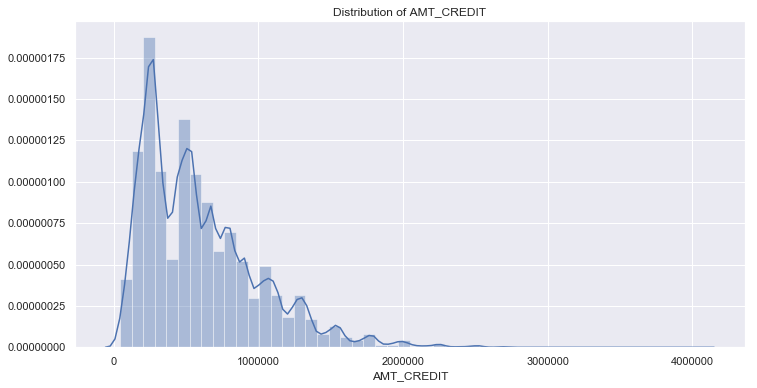

In [3]:
#################distribution of AMT_CREDIT############################

plt.figure(figsize=(12,6))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(df_application_train["AMT_CREDIT"])

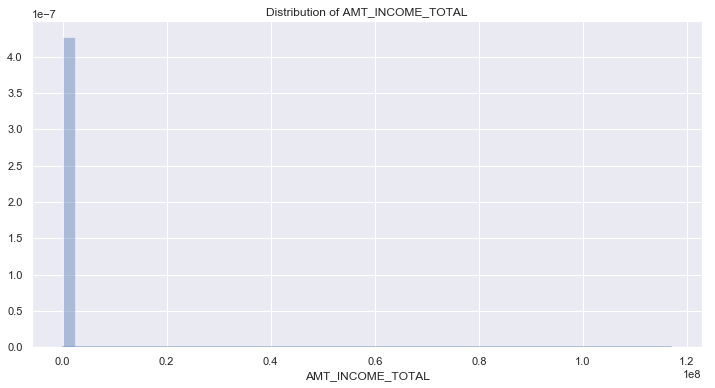

In [4]:
####################### Distribution of AMT_INCOME_TOTAL ##########################

plt.figure(figsize=(12,6))
plt.title("Distribution of AMT_INCOME_TOTAL")

ax = sns.distplot(df_application_train["AMT_INCOME_TOTAL"].dropna())

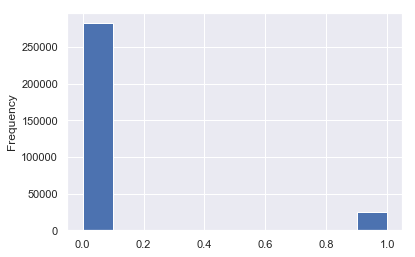

In [5]:
##################distribution of target and to check whether the data set is imbalanced or balanced#################

df_application_train['TARGET'].astype(int).plot.hist();
# the data set is highly unbalanced 
# Target variable
# (1 - client with payment difficulties: 
#      he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample,
#  0 - all other cases)

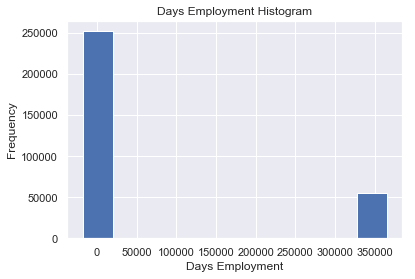

In [6]:
#######################days_employed plot###############################

df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [7]:
# detecting outliers

# sns.boxplot(x=df_application_train[''])


def analyse_outliers(df, column):
    
    # Print Summary Statistics
    print('Summary Statistics:\n')
    print(df[column].describe())

    # find mean and std
    outlier_df = df[column]
    std = outlier_df.std()
    print('\nStandard Deviation: ', std)
    mean =  outlier_df.mean()
    print('Mean: ', mean)

    # how many std is the max
    max_outlier = int((outlier_df.max() - mean) / std)

    # separate outliers over 2 std from mean
    outliers_l = outlier_df[(outlier_df < mean - 2 * std)]
    outliers_h = outlier_df[(outlier_df > mean + 2 * std)]
    print('\nThere are {} low end outliers in the {} dataset'.format(len(outliers_l), column ))    
    print('There are {} high end outliers in the {} dataset'.format(len(outliers_h), column ))
    print('The max value is {} standard deviations from the mean'.format(max_outlier))
    
    return mean, std

income_mean, income_std = analyse_outliers(df_application_train, 'AMT_INCOME_TOTAL')   




###>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Summary Statistics:

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

Standard Deviation:  237123.14627883647
Mean:  168797.9192969845

There are 0 low end outliers in the AMT_INCOME_TOTAL dataset
There are 1438 high end outliers in the AMT_INCOME_TOTAL dataset
The max value is 492 standard deviations from the mean


In [8]:
#####################################

# df_application_train[df_application_train['AMT_INCOME_TOTAL'] < 2000000]['AMT_INCOME_TOTAL'].iplot(kind='histogram', bins=100,
#    xTitle = 'Total Income', yTitle ='Count of applicants',
#              title='Distribution of AMT_INCOME_TOTAL')

In [9]:
#############################relationship between target and birthdays#####################################################
# Find the correlation of the positive days since birth and target


df_application_train['DAYS_BIRTH'] = abs(df_application_train['DAYS_BIRTH'])
df_application_train['DAYS_BIRTH'].corr(df_application_train['TARGET'])

-0.07823930830982712

[Text(0, 0, '351000.0'),
 Text(0, 0, '1129500.0'),
 Text(0, 0, '135000.0'),
 Text(0, 0, '297000.0'),
 Text(0, 0, '513000.0'),
 Text(0, 0, '454500.0'),
 Text(0, 0, '1395000.0')]

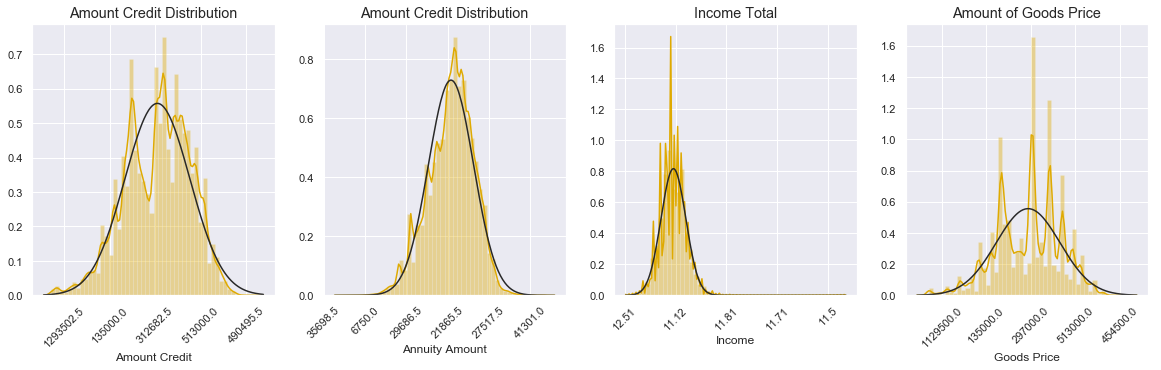

In [10]:
######################distribution analysis AMT_ANNUITY, AMT_CREDIT, AMT_INCOME_TOTAL,AMT_GOODS_PRICE #######################
##this code snippet those distributions are right-skewed , symetric (normal distribution) or left-skewed 
####We will use the norm function from scipy


f, axes = plt.subplots(ncols=4, figsize=(20,5)) 
plt.style.use('ggplot')

annuity_dist = df_application["AMT_ANNUITY"].dropna()

# Distributions 
sns.distplot(np.log(df_application["AMT_CREDIT"]), kde=True, color="#DFAA01", ax=axes[0], fit= norm).set_title("Amount Credit Distribution")
axes[0].set_xlabel("Amount Credit")
axes[0].set_xticklabels(df_application["AMT_CREDIT"], rotation=45)

sns.distplot(np.log(annuity_dist), color="#DFAA01", ax=axes[1] ,fit= norm).set_title("Amount Credit Distribution")
axes[1].set_xlabel("Annuity Amount")
axes[1].set_xticklabels(annuity_dist, rotation=45)

# Let's use this using log (Without log it is heavily skewed)
log_income = np.around(np.log(df_application["AMT_INCOME_TOTAL"]),2)

sns.distplot(log_income, kde=True, color="#DFAA01", ax=axes[2],fit= norm).set_title("Income Total")
axes[2].set_xlabel("Income")
axes[2].set_xticklabels(log_income, rotation=45)

# Amount Goods Price
price_withoutna = df_application["AMT_GOODS_PRICE"].dropna()

sns.distplot(np.log(price_withoutna), kde=True, color="#DFAA01", fit= norm,ax=axes[3]).set_title("Amount of Goods Price")
axes[3].set_xlabel("Goods Price")
axes[3].set_xticklabels(price_withoutna, rotation=45)

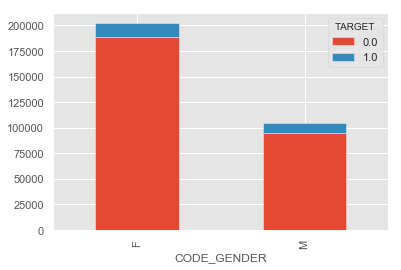

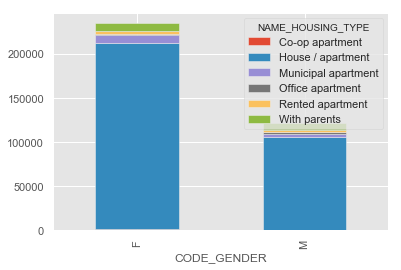

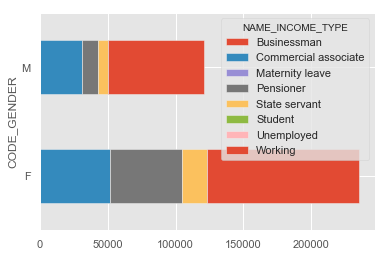

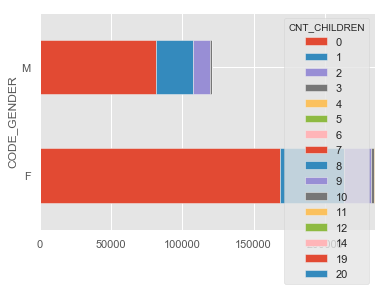

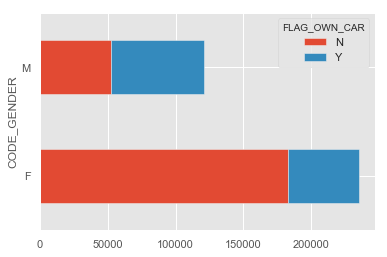

In [11]:
#########################################gender analysis######################################
######distribution by Gender

genders = df_application.loc[(df_application['CODE_GENDER'] == 'M') | (df_application['CODE_GENDER'] == 'F')]

gender_housing_type = genders.groupby(['CODE_GENDER', 'TARGET']).size()
gender_housing_type.unstack().plot(kind='bar', stacked=True)

gender_housing_type = genders.groupby(['CODE_GENDER', 'NAME_HOUSING_TYPE']).size()
gender_housing_type.unstack().plot(kind='bar', stacked=True)

gender_income = genders.groupby(['CODE_GENDER', 'NAME_INCOME_TYPE']).size()
gender_income.unstack().plot(kind='barh', stacked=True)

gender_income = genders.groupby(['CODE_GENDER', 'CNT_CHILDREN']).size()
gender_income.unstack().plot(kind='barh', stacked=True)

gender_income = genders.groupby(['CODE_GENDER', 'FLAG_OWN_CAR']).size()
gender_income.unstack().plot(kind='barh', stacked=True)


In [12]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in df_frames:
    #print('{}'.format(df))
    display_missing(df)
    

SK_ID_CURR column missing values: 0
TARGET column missing values: 0
NAME_CONTRACT_TYPE column missing values: 0
CODE_GENDER column missing values: 0
FLAG_OWN_CAR column missing values: 0
FLAG_OWN_REALTY column missing values: 0
CNT_CHILDREN column missing values: 0
AMT_INCOME_TOTAL column missing values: 0
AMT_CREDIT column missing values: 0
AMT_ANNUITY column missing values: 12
AMT_GOODS_PRICE column missing values: 278
NAME_TYPE_SUITE column missing values: 1292
NAME_INCOME_TYPE column missing values: 0
NAME_EDUCATION_TYPE column missing values: 0
NAME_FAMILY_STATUS column missing values: 0
NAME_HOUSING_TYPE column missing values: 0
REGION_POPULATION_RELATIVE column missing values: 0
DAYS_BIRTH column missing values: 0
DAYS_EMPLOYED column missing values: 0
DAYS_REGISTRATION column missing values: 0
DAYS_ID_PUBLISH column missing values: 0
OWN_CAR_AGE column missing values: 202929
FLAG_MOBIL column missing values: 0
FLAG_EMP_PHONE column missing values: 0
FLAG_WORK_PHONE column missi

AMT_REQ_CREDIT_BUREAU_WEEK column missing values: 6049
AMT_REQ_CREDIT_BUREAU_MON column missing values: 6049
AMT_REQ_CREDIT_BUREAU_QRT column missing values: 6049
AMT_REQ_CREDIT_BUREAU_YEAR column missing values: 6049




In [13]:
threshold = 0.75
# #Dropping columns with missing value rate higher than threshold
df_application_train = df_application_train[df_application_train.columns[df_application_train.isnull().mean() < threshold]]
df_application_test = df_application_test[df_application_test.columns[df_application_test.isnull().mean() < threshold]]

# #Dropping rows with missing value rate higher than threshold
df_application_train = df_application_train.loc[df_application_train.isnull().mean(axis=1) < threshold]
# print(df_application_train)


df_application_test = df_application_test.loc[df_application_test.isnull().mean(axis=1) < threshold]
# print(df_application_test)


#Filling missing values with mode of the columns
df_application_train = df_application_train.fillna(df_application_train.median())


###### categorical data#########
categorical_feature_mask = df_application_train.dtypes==object
categorical_cols = df_application_train.columns[categorical_feature_mask].tolist()

for col in categorical_cols:
    print(col)
    df_application_train[col].fillna(df_application_train[col].value_counts().idxmax(), inplace=True)
print("train data shape",df_application_train.shape)


df_application_test = df_application_test.dropna()
print("test data shape",df_application_test.shape)



NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
train data shape (307511, 122)
test data shape (1739, 121)


In [14]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

display_missing(df_application_train)
display_missing(df_application_test)




SK_ID_CURR column missing values: 0
TARGET column missing values: 0
NAME_CONTRACT_TYPE column missing values: 0
CODE_GENDER column missing values: 0
FLAG_OWN_CAR column missing values: 0
FLAG_OWN_REALTY column missing values: 0
CNT_CHILDREN column missing values: 0
AMT_INCOME_TOTAL column missing values: 0
AMT_CREDIT column missing values: 0
AMT_ANNUITY column missing values: 0
AMT_GOODS_PRICE column missing values: 0
NAME_TYPE_SUITE column missing values: 0
NAME_INCOME_TYPE column missing values: 0
NAME_EDUCATION_TYPE column missing values: 0
NAME_FAMILY_STATUS column missing values: 0
NAME_HOUSING_TYPE column missing values: 0
REGION_POPULATION_RELATIVE column missing values: 0
DAYS_BIRTH column missing values: 0
DAYS_EMPLOYED column missing values: 0
DAYS_REGISTRATION column missing values: 0
DAYS_ID_PUBLISH column missing values: 0
OWN_CAR_AGE column missing values: 0
FLAG_MOBIL column missing values: 0
FLAG_EMP_PHONE column missing values: 0
FLAG_WORK_PHONE column missing values: 

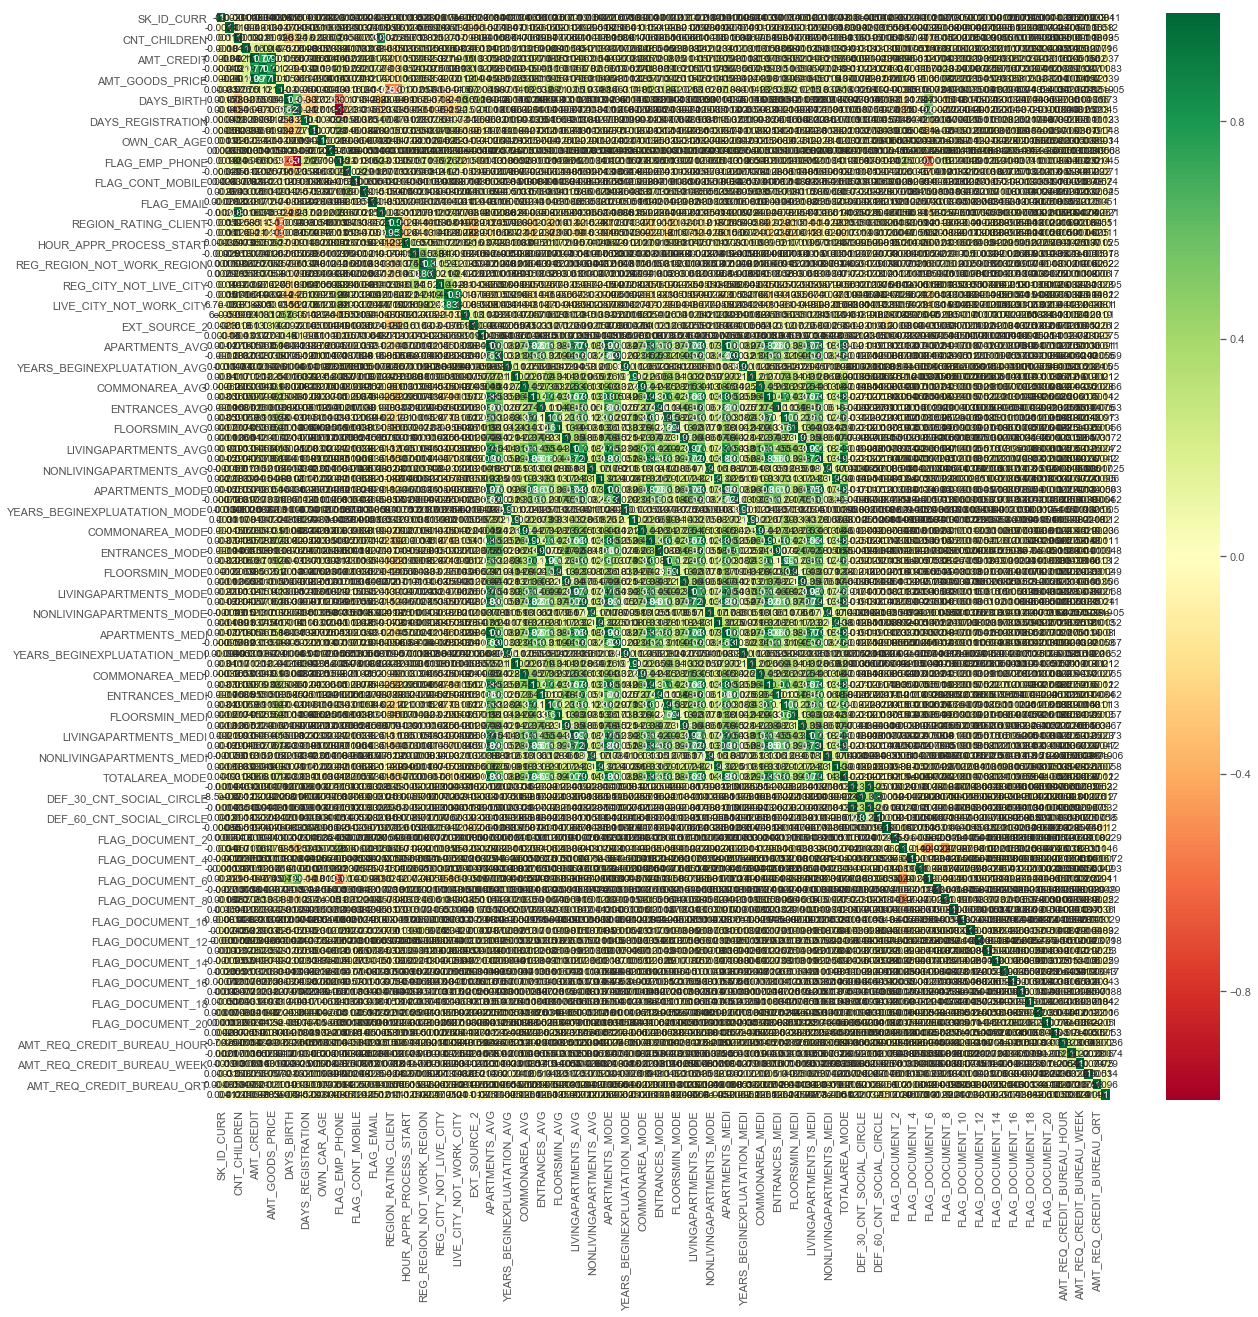

In [15]:
#get correlations of each features in dataset
corrmat = df_application_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_application_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [16]:
################ data encoding ####################

##### for training data set ###########
categorical_feature_mask = df_application_train.dtypes==object
# filter categorical columns using mask and turn it into a list
non_numeric_features = df_application_train.columns[categorical_feature_mask].tolist()
print(non_numeric_features)

le = LabelEncoder()
df_application_train[non_numeric_features] = df_application_train[non_numeric_features].apply(lambda col: le.fit_transform(col))
print(df_application_train.shape)


#### for test data  #####
categorical_feature_mask_test = df_application_test.dtypes==object
# filter categorical columns using mask and turn it into a list
non_numeric_features_test = df_application_test.columns[categorical_feature_mask_test].tolist()
print(non_numeric_features_test)

le = LabelEncoder()
df_application_test[non_numeric_features_test] = df_application_test[non_numeric_features_test].apply(lambda col: le.fit_transform(col))
print(df_application_test.shape)



['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
(307511, 122)
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
(1739, 121)


In [17]:
###################### normalization of data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(df_application_train)
df_application_train_norm = scaler.transform(df_application_train)
print(df_application_train_norm.shape)

scaler.fit(df_application_test)
df_application_test_norm = scaler.transform(df_application_test)
print(df_application_test_norm.shape)


(307511, 122)
(1739, 121)


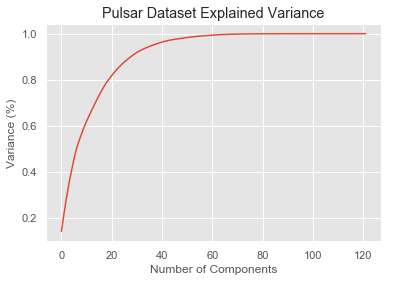

In [18]:
##################### dimension reduction ################### 

############ number of pca component analysis ###############


scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(df_application_train)


#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()




In [19]:
############ Make a pipeline with imputation and pca

from sklearn.decomposition import PCA
# pca = PCA(n_components=30 , random_state=420)
# pca = PCA(n_components=40 , random_state=420)
# pca = PCA(n_components=50 , random_state=420)

pca = PCA(n_components=60 , random_state=420)
pca_test = PCA(n_components=59 , random_state=420)


df_application_train_pca = pca.fit_transform(df_application_train_norm)
df_application_test_pca = pca_test.fit_transform(df_application_test_norm)

print(df_application_train_pca.shape)
print(df_application_test_pca.shape)





(307511, 60)
(1739, 59)


In [20]:
################## x _train , y_train , x_test #################

df =  pd.DataFrame(df_application_train_pca)
 # print(df)
X_train = df.drop([df.columns[0], df.columns[1]] ,  axis='columns')
print(X_train.shape)
y_train = df_application_train['TARGET']
# # print(y_train)


df1 = pd.DataFrame(df_application_test_pca)  
X_test_data =  df1.drop(df.columns[0],  axis='columns')
print(X_test_data.shape)



df =  pd.DataFrame(df_application_train_pca)
# print(df)
X = df.drop([df.columns[0], df.columns[1]] ,  axis='columns')
y = df_application_train['TARGET']
# print(X)
print(y)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1)



(307511, 58)
(1739, 58)
0         1
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        1
27        0
28        0
29        0
         ..
307481    1
307482    0
307483    0
307484    0
307485    0
307486    0
307487    0
307488    0
307489    1
307490    0
307491    0
307492    0
307493    0
307494    0
307495    0
307496    0
307497    0
307498    0
307499    0
307500    0
307501    0
307502    0
307503    0
307504    0
307505    0
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64


In [22]:
# #################### kNN model for various k values #############

k_range = range(1, 10)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print("k value" ,k)
    
    print("confusion matrix")
    print(confusion_matrix(y_test,y_pred))

    # predict probabilities
    probs = knn.predict_proba(X_test)
    probs = probs[:, 1]
    

    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
#     # calculate F1 score
  #  f1 = f1_score(y_test, y_pred)
#     # calculate precision-recall AUC
  #  auc = auc(recall, precision)
#     # calculate average precision score
  #  ap = average_precision_score(y_test, probs)
  #  print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
#     # plot no skill
#     pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
#     # plot the precision-recall curve for the model
#     pyplot.plot(recall, precision, marker='.')
#     # show the plot
#     pyplot.show()




k value 1
confusion matrix
[[56528     5]
 [  173  4797]]
k value 2
confusion matrix
[[56533     0]
 [  350  4620]]
k value 3
confusion matrix
[[56532     1]
 [  140  4830]]
k value 4
confusion matrix
[[56533     0]
 [  239  4731]]
k value 5
confusion matrix
[[56533     0]
 [  146  4824]]
k value 6
confusion matrix
[[56533     0]
 [  202  4768]]
k value 7
confusion matrix
[[56533     0]
 [  124  4846]]
k value 8
confusion matrix
[[56533     0]
 [  189  4781]]


KeyboardInterrupt: 

In [23]:
######################## logistic regression algorithm #######################

logmodel = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver= 'lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(predictions)


print("confusion matrix")
print(confusion_matrix(y_test,y_pred))

# # predict probabilities
# probs = logmodel.predict_proba(X_test)
# probs = probs[:, 1]

# # calculate AUC
# auc = roc_auc_score(y_test, probs)
# print('AUC: %.3f' % auc)
# # calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_test, probs)
# # plot no skill
# pyplot.plot([0, 1], [0, 1], linestyle='--')
# # plot the roc curve for the model
# pyplot.plot(fpr, tpr, marker='.')
# # show the plot
# pyplot.show()



[1 0 0 ... 0 0 0]
confusion matrix
[[56533     0]
 [  189  4781]]


In [25]:
# ######################## decision tree algorithm #######################
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=3, min_samples_leaf=5) 
  
# #### Performing training 
clf_gini.fit(X_train, y_train)


# #### Train Decision Tree Classifer
clf = .fit(X_train,y_train)

# ####Predict the reclf_ginisponse for test dataset
y_pred = clf.predict(X_test)


clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
print(predictions)


print("confusion matrix")
print(confusion_matrix(y_test,y_pred))

[1 0 0 ... 0 0 0]
confusion matrix
[[56504    29]
 [  273  4697]]


In [ ]:
######################## svm algorithm #######################
####linear kernel
svc_model = SVC(kernel='linear').fit(X_train, y_train)
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
print ("Predicted Value:", y_pred)
# #################### kNN model for various k values #############


print("confusion matrix")
print(confusion_matrix(y_test,y_pred))

# predict probabilities
# probs = svc_model.predict_proba(X_test)
# probs = probs[:, 1]

# # calculate precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_test, probs)
# # calculate F1 score
# f1 = f1_score(y_test, y_pred)
# # calculate precision-recall AUC
# #     auc = auc(recall, precision)
# # calculate average precision score
# ap = average_precision_score(y_test, probs)
# #     print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# # plot no skill
# pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
# # plot the precision-recall curve for the model
# pyplot.plot(recall, precision, marker='.')
# # show the plot
# pyplot.show()




#####rbf kernel
svc_model = SVC(kernel='rbf').fit(X_train, y_train)
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
print ("Predicted Value:", y_pred)
print("confusion matrix")
print(confusion_matrix(y_test,y_pred))

# predict probabilities
# probs = svc_model.predict_proba(X_test)
# probs = probs[:, 1]

# # # calculate precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_test, probs)
# # calculate F1 score
# f1 = f1_score(y_test, y_pred)
# # calculate precision-recall AUC
# #     auc = auc(recall, precision)
# # calculate average precision score
# ap = average_precision_score(y_test, probs)
# #     print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# # plot no skill
# pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
# # plot the precision-recall curve for the model
# pyplot.plot(recall, precision, marker='.')
# # show the plot
# pyplot.show()




####poly kernel
svc_model = SVC(kernel='poly').fit(X_train, y_train)
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
print ("Predicted Value:", y_pred)
print("confusion matrix")
print(confusion_matrix(y_test,y_pred))

# predict probabilities
# probs = svc_model.predict_proba(X_test)
# probs = probs[:, 1]

# # # calculate precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_test, probs)
# # calculate F1 score
# f1 = f1_score(y_test, y_pred)
# # calculate precision-recall AUC
# #     auc = auc(recall, precision)
# # calculate average precision score
# ap = average_precision_score(y_test, probs)
# #     print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# # plot no skill
# pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
# # plot the precision-recall curve for the model
# pyplot.plot(recall, precision, marker='.')
# # show the plot
# pyplot.show()


Predicted Value: [1 0 0 ... 0 0 0]
confusion matrix
[[56533     0]
 [    0  4970]]


C:\Users\binuri\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\binuri\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Predicted Value: [1 0 0 ... 0 0 0]
confusion matrix
[[56533     0]
 [    0  4970]]


C:\Users\binuri\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\binuri\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
#################test out data set 
y_pred_test = svc_model.predict(X_test_data)
print ("Predicted Value:", y_pred_test)
# #################### kNN model for various k values #############

